### TODO FOR BOI AG

- Patches
    - Numpy array med patches 
        - Param > False image / true patches
        - Param > training or testing
        - Returns x_train, y_train, x_test, y_test
    - Rotation
  
- Patches to image
    - PARAMS lista med patches
- Keras generator

FIX PERMUTATION



In [14]:
import os
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from skimage.transform import resize
 

def lower_res(x, channels, res):
    return np.asarray(resize(x, (res, res, channels)))

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        if (i + h > imgheight):
            continue 
        for j in range(0,imgwidth,w):
            if (j + w > imgwidth):
                continue 
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches


def patches_split(x, y, patch_size, split):
    assert len(x) == len(y), "Length of x and y has to be the same"
    perm = np.random.permutation(len(x))
    split_perm = int(len(x)*split)
    train_perm = perm[:split_perm]
    test_perm = perm[split_perm:]
    
    x_tr_img_patches = [img_crop(x[i], patch_size, patch_size) for i in train_perm]
    x_train = np.asarray([x_tr_img_patches[i][j] for i in range(len(x_tr_img_patches)) for j in range(len(x_tr_img_patches[i]))])
    x_te_img_patches = [img_crop(x[i], patch_size, patch_size) for i in test_perm]
    x_test = np.asarray([x_te_img_patches[i][j] for i in range(len(x_te_img_patches)) for j in range(len(x_te_img_patches[i]))])
    
    y_tr_img_patches = [img_crop(y[i], patch_size, patch_size) for i in train_perm]
    y_train = np.asarray([y_tr_img_patches[i][j] for i in range(len(y_tr_img_patches)) for j in range(len(y_tr_img_patches[i]))])
    y_te_img_patches = [img_crop(y[i], patch_size, patch_size) for i in test_perm]
    y_test = np.asarray([y_te_img_patches[i][j] for i in range(len(y_te_img_patches)) for j in range(len(y_te_img_patches[i]))])
    
    return x_train, x_test, y_train, y_test


def data_generator(patch_size, num_images = 100, train_test_ratio = 0.8, rotation_degs = []):
    """
    Generate data from images, contruct patches and split data into train/test set
    
    Returns:
        x_train, x_test, y_train, y_test
    """
    x_filename = './data/training/images/'
    y_filename = './data/training/groundtruth/'
    x_imgs = []
    y_imgs = []
    
    # Load all images
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        x_image_filename = "../" + x_filename + imageid + ".png"
        y_image_filename = "../" + y_filename + imageid + ".png"
        if os.path.isfile(x_image_filename) and os.path.isfile(y_image_filename):
            x_img = lower_res(mpimg.imread(x_image_filename), 3, 128)
            x_imgs.append(x_img)
            y_img = lower_res(mpimg.imread(y_image_filename), 1, 128)
            y_imgs.append(y_img)
        else:
            print('File ' + image_filename + ' does not exist') 
    
    num_images = len(x_imgs)
    IMG_WIDTH = x_imgs[0].shape[0]
    IMG_HEIGHT = x_imgs[0].shape[1]
    assert x_imgs[0].shape[0]%patch_size == 0 , "patch size is not multiple of image width/height"

    x_train, x_test, y_train, y_test = patches_split(x_imgs, y_imgs, patch_size, train_test_ratio)
    
    for deg in rotation_degs:
        print(deg)
        x_rotated_imgs = []
        y_rotated_imgs = []
        for i in range(num_images):
            x_rotated_imgs.append(ndimage.rotate(x_imgs[i], deg, reshape=True, mode='mirror'))
            y_rotated_imgs.append(ndimage.rotate(y_imgs[i], deg, reshape=True, mode='mirror'))
            
        x_train_rot, x_test_rot, y_train_rot, y_test_rot = patches_split(x_rotated_imgs, y_rotated_imgs, 
                                                                         patch_size, train_test_ratio)
        
        x_train = np.concatenate([x_train, x_train_rot, x_test_rot])
        y_train = np.concatenate([y_train, y_train_rot, y_test_rot])

    return x_train, x_test, y_train, y_test

def patches_to_images(patches, patch_size, img_side_len=400):
    """
    takes an array of patches and integer of patch_size
    returns an array of images
    """
    assert patches.shape[0]%(img_side_len/patch_size)**2==0, "Uneven number of patches given image and patch size"
    
    num_patches_img = (img_side_len/patch_size) ** 2
    num_imgs = int(patches.shape[0]/num_patches_img)
    imgs = []
    
    
    tot_index = 0
    for img in range(num_imgs):
        img_index = 0
        image = []
        for row in range(int(np.sqrt(num_patches_img))):
            img_row = []
            for col in range(int(np.sqrt(num_patches_img))):
                if len(img_row)==0:
                    img_row = patches[tot_index]
                else:
                    img_row = np.append(img_row, patches[tot_index], axis=0)
                tot_index += 1
            if len(image)==0:
                image = img_row
            else:
                image = np.append(image, img_row, axis=1)
        imgs.append(image)
        
    return np.asarray(imgs)


In [30]:
x_train, x_test, y_train, y_test=data_generator(128, num_images = 100, rotation_degs=[20,40])
x_train.shape

20
40


(280, 128, 128, 3)

In [4]:
np.save('../data/training/patches/x_train.npy', x_train)
np.save('../data/training/patches/x_test.npy', x_test)
np.save('../data/training/patches/y_train.npy', y_train)
np.save('../data/training/patches/y_test.npy', y_test)

In [2]:
import numpy as np
a = np.zeros((8000, 128, 128, 3), dtype='float32')
b = 0#np.zeros((2000, 400, 400, 3), dtype='float32')

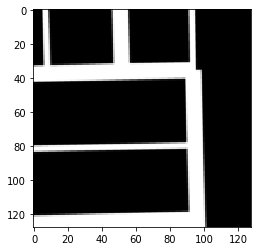

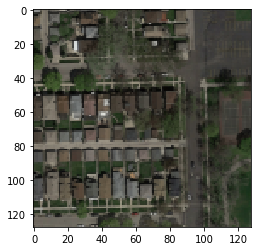

In [28]:
plt.imshow(y_train[2].reshape((128,128)), cmap='gray')
plt.show()
plt.imshow(x_train[2])